In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
from scipy.stats import f_oneway, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import gensim.models

import warnings
warnings.filterwarnings('ignore')

# 1) Define all useful functions

In [2]:
def parse_proficiency(prof_str):
    """
    Parses the proficiency string (e.g., "9,7,5,3") into a list of floats.
    Handles potential non-numeric characters or formatting issues.
    """
    if pd.isna(prof_str):
        return []
    # Remove any non-numeric characters except comma and decimal point
    cleaned_str = re.sub(r'[^\d,.]', '', str(prof_str))
    try:
        # Split and convert to float, filtering out empty strings
        scores = [float(s.strip()) for s in cleaned_str.split(',') if s.strip()]
        # Ensure scores are positive for log transformation
        scores = [max(s, 1e-9) for s in scores] # Add small epsilon to avoid log(0)
        return scores
    except ValueError:
        print(f"Warning: Could not parse proficiency string: {prof_str}")
        return []

In [3]:
def calculate_MPS(profile: list[float], max_languages: int = 10, max_proficiency: float = 10.0) -> float:
    """
    Calculates a normalized Multilingual Proficiency Score.
    The score considers both the number of languages spoken and the proficiency
    level in each, normalized to a value between 0.0 and 1.0. It uses the
    sum of the square roots of proficiency scores. This model rewards a
    balanced profile, satisfying the condition where [3, 3] is considered
    better than [5, 1].
    Args:
        profile (list[float]): A list of proficiency scores for a participant.
                               Each score is expected to be between 1.0 and
                               max_proficiency.
        max_languages (int): The maximum number of languages a person can list.
                             This is used to calculate the normalization ceiling.
        max_proficiency (float): The maximum possible proficiency score for any
                                 single language.
    Returns:
        float: A single, normalized score between 0.0 and 1.0.
    Raises:
        TypeError: If the input 'profile' is not a list.
        ValueError: If the profile contains more than max_languages or if any
                    score is outside the valid range [1.0, max_proficiency].
    """
    # --- 1. Input Validation ---
    if not isinstance(profile, list):
        raise TypeError("Input 'profile' must be a list of numbers.")
    if len(profile) > max_languages:
        raise ValueError(
            f"Profile cannot contain more than {max_languages} languages.")
    if any(not (1.0 <= score <= max_proficiency) for score in profile):
        raise ValueError(
            f"All scores in profile must be between 1.0 and {max_proficiency}.")
    # --- 2. Handle the Edge Case of an Empty Profile ---
    if not profile:
        return 0.0
    # --- 3. Calculate the Raw Score (Sum of Square Roots) ---
    # This model provides a more balanced view of proficiency by reducing the
    # weight of exceptionally high scores compared to a sum-of-squares model.
    raw_score = sum(score**0.5 for score in profile)
    # --- 4. Determine the Maximum Possible Score for Normalization ---
    # This corresponds to a profile with the maximum number of languages,
    # all at the maximum proficiency level, using the square root model.
    max_raw_score = max_languages * (max_proficiency**0.5)
    # --- 5. Normalize the Score and Return ---
    # Avoid division by zero, though unlikely with default arguments.
    if max_raw_score == 0:
        return 0.0
    normalized_score = raw_score / max_raw_score
    return normalized_score

In [4]:
def calculate_semantic_distance(target, associates, model):
    """
    Calculates the average cosine distance between a target word and its associates
    using the standard Gensim API. Handles words potentially not in the vocabulary.

    Args:
        target (str): The target word.
        associates (list): A list of associated words (strings).
        model: A loaded gensim KeyedVectors model (e.g., from load_facebook_vectors).

    Returns:
        The average cosine distance, or np.nan if calculation fails
        (e.g., target not usable, or no valid associates found in the model).
    """
    # --- Input Validation ---
    if pd.isna(target) or not isinstance(target, str) or not associates:
        return np.nan

    # Clean associate list (remove potential NaNs or non-strings if list comes from pandas)
    associates = [word for word in associates if isinstance(word, str) and pd.notna(word)]
    if not associates:
        return np.nan

    # --- Check Target Word ---
    # Use 'in' operator - the standard way to check vocabulary presence
    # For FastText, this checks the known vocabulary learned during training.
    # It does NOT check if an OOV vector *could* be generated.
    if target not in model:
        # print(f"Warning: Target word '{target}' not in model vocabulary.")
        return np.nan

    # --- Calculate Distances ---
    distances = []
    for assoc in associates:
        # Use 'in' operator for associates too
        if assoc in model:
            try:
                # Use the built-in model.similarity method.
                # It's efficient and handles vector normalization.
                # For FastText, this uses vectors from the known vocabulary.
                similarity = model.similarity(target, assoc)

                # Cosine distance = 1 - similarity
                distance = 1.0 - similarity
                distances.append(distance)

            except KeyError:
                # This is a safeguard, model.similarity might raise KeyError
                # if a word passed the 'in' check but somehow isn't retrievable.
                # print(f"Warning: Could not compute similarity between '{target}' and '{assoc}'.")
                pass # Skip this associate
        # else:
            # print(f"Warning: Associate word '{assoc}' for target '{target}' not in model vocabulary.")
            # Skip associate if not in model (implicit from the 'if assoc in model' check)

    # --- Return Result ---
    if not distances:
        # This happens if the target was found, but none of its valid associates were.
        # print(f"Warning: Target '{target}' found, but none of its valid associates were in the model vocabulary.")
        return np.nan

    return np.mean(distances)

# 2) Input/output paths configuration and data loading

In [5]:
LEAPQ_FILE = 'results_LEAPQ.xlsx'
TOT_FILE = 'results_TOT.xlsx'
ASSOCIATION_FILE = 'results_association.xlsx'

# Create the directories to save plots if they don't exist
output_dir = os.path.join('figures')
os.makedirs(output_dir, exist_ok=True)

# You need a pre-trained word embedding model for French.
# Download one (e.g., from fastText: https://fasttext.cc/docs/en/crawl-vectors.html)
# and update the path below.
# Example using gensim downloader (requires internet connection first time):
#import gensim.downloader as api
#model_path = api.load('fasttext-fr-300d-1M', return_path=True) # Example model
# Or provide a direct path to the downloaded file:
# Replace this path with the ACTUAL path where you saved the downloaded file
WORD_EMBEDDING_MODEL_PATH = '/Users/borghesani/Documents/5_Students/UNIGE_master_students/5_Neuro/Lina_Languer/cc.fr.300.bin' # or .bin
LOAD_EMBEDDINGS = True # Set to False if you don't have a model or want to skip this part

print("Loading data...")
try:
    df_leapq = pd.read_excel(LEAPQ_FILE)
    df_tot = pd.read_excel(TOT_FILE)
    df_association = pd.read_excel(ASSOCIATION_FILE)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure the Excel files (results_LEAPQ.xlsx, results_TOT.xlsx, results_association.xlsx) are in the correct directory.")
    exit() # Exit if files are not found

# Clean column names (remove leading/trailing spaces, replace spaces with underscores)
def clean_col_names(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^A-Za-z0-9_]+', '', regex=True)
    return df

df_leapq = clean_col_names(df_leapq)
df_tot = clean_col_names(df_tot)
df_association = clean_col_names(df_association)

# Ensure Participant_ID is the same type for merging (string or int)
df_leapq['Participant_ID'] = df_leapq['Participant_ID'].astype(str)
df_tot['Participant_ID'] = df_tot['Participant_ID'].astype(str)
df_association['Participant_ID'] = df_association['Participant_ID'].astype(str)

# Collaps Said_I_Know_but_ToT & ToT and rename
df_tot['ToT_new'] = df_tot['Said_I_Know_but_ToT'] + df_tot['ToT']
df_final = df_tot[['Participant_ID', 'Said_I_Know_Correctly', 'Said_I_Know_but_Error', 'ToT_new', 'I_Dont_Know']].rename(columns={
    'Said_I_Know_Correctly': 'Correct',
    'Said_I_Know_but_Error': 'Error',
    'ToT_new': 'ToT',
    'I_Dont_Know': 'Unknown'
})

# Appropriately map the trials of the association task
score_map = {
    1: 'Correct',
    2: 'Error',
    3: 'ToT',
    4: 'ToT'  # Note: Both 3 and 4 map to 'ToT'
}
df_association['Score'] = df_association['Score'].map(score_map)

print("Data cleaned and prepared")

Loading data...
Data loaded successfully.
Data cleaned and prepared


# 3) Demographics & MPS calculation

In [6]:
print("\n--- Demographic Summary ---")
mean_age = df_leapq['Age'].mean()
std_age = df_leapq['Age'].std()
min_age = df_leapq['Age'].min()
max_age = df_leapq['Age'].max()
gender_counts = df_leapq['Sex'].value_counts(normalize=True) * 100
mean_languages = df_leapq['Number_of_Languages'].mean()
std_languages = df_leapq['Number_of_Languages'].std()
total_participants = len(df_leapq)

print(f"Total Participants: {total_participants}")
print(f"Age: Mean={mean_age:.2f}, SD={std_age:.2f}, Range=({min_age}-{max_age})")
print("Gender Distribution:")
print(gender_counts.to_string())
print(f"Number of Languages Spoken: Mean={mean_languages:.2f}, SD={std_languages:.2f}")


--- Demographic Summary ---
Total Participants: 35
Age: Mean=24.23, SD=7.00, Range=(19-46)
Gender Distribution:
Sex
F    77.142857
M    22.857143
Number of Languages Spoken: Mean=4.31, SD=1.30



Calculating MPS...
MPS calculated.
  Participant_ID  Proficiency       MPS
0          10973     10,6,8,6  0.344362
1          10974       10,9,7  0.278534
2          10975  10,10,8,6,4  0.430148
3          10979       10,8,7  0.273109
4          10980        7,9,7  0.262200
The Pearson correlation coefficient between MPS and number of languages spoken is: 0.9492


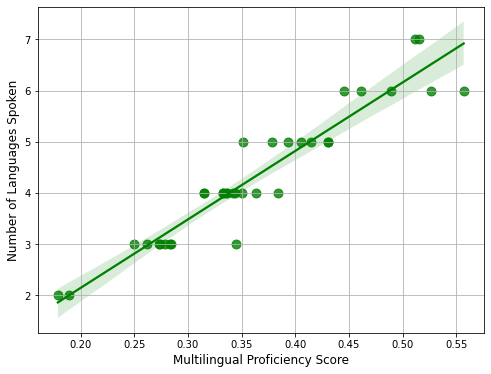

In [7]:
print("\nCalculating MPS...")
if 'Proficiency' in df_leapq.columns:
    df_leapq['Proficiency_Scores'] = df_leapq['Proficiency'].apply(parse_proficiency)
    df_leapq['MPS'] = df_leapq['Proficiency_Scores'].apply(calculate_MPS)
    print("MPS calculated.")
    print(df_leapq[['Participant_ID', 'Proficiency', 'MPS']].head())
else:
    print("Warning: 'Proficiency' column not found in LEAPQ data. Skipping MPS calculation.")
    df_leapq['MPS'] = np.nan # Add MLP column with NaNs

correlation = df_leapq['Number_of_Languages'].corr(df_leapq['MPS'])
print(f"The Pearson correlation coefficient between MPS and number of languages spoken is: {correlation:.4f}")
plt.figure(figsize=(8, 6)) # Set the figure size for better readability
sns.regplot(x='MPS', y='Number_of_Languages', data=df_leapq,
            scatter_kws={'s': 80}, # Make the points larger
            color='green') # Chose the color
plt.xlabel('Multilingual Proficiency Score', fontsize=12)
plt.ylabel('Number of Languages Spoken', fontsize=12)
plt.grid(True)
plot_save_path = os.path.join(output_dir, 'MPS_languages.png')
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()

# 4) Merging the datasets

In [8]:
print("\nMerging datasets...")

# Final merge for TOT task
df_merged_final = pd.merge(df_final, df_leapq, on='Participant_ID', how='left')

# Final merge for Word Association task
df_merged = pd.merge(df_association, df_leapq, on='Participant_ID', how='left')
assoc_cols = [col for col in df_merged.columns if col.startswith('Word_')]
df_merged['Associates'] = df_merged[assoc_cols].apply(lambda row: row.dropna().tolist(), axis=1)

print("Datasets merged.")


Merging datasets...
Datasets merged.


# 5) Hypothesis 1:  Multilingualism and ToT Frequency


Correlations between MPS and Retrieval Outcomes:
  - MPS vs. Correct: r = 0.0743, p = 0.6714
  - MPS vs. ToT: r = 0.2837, p = 0.0986
  - MPS vs. Error: r = 0.1286, p = 0.4617
  - MPS vs. Unknown: r = -0.3257, p = 0.0562




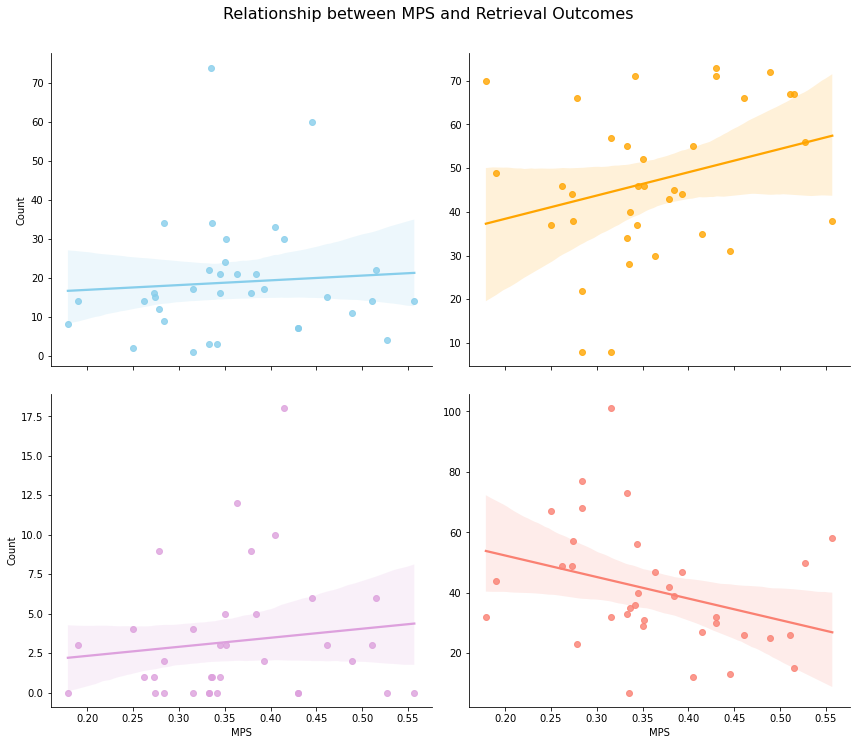

In [9]:
# Calculate and print the correlation for each outcome type against MPS
print("\nCorrelations between MPS and Retrieval Outcomes:")
for outcome in ['Correct', 'ToT', 'Error', 'Unknown']:
    # Calculate Pearson correlation and p-value
    corr, p_value = pearsonr(df_merged_final['MPS'], df_merged_final[outcome])
    print(f"  - MPS vs. {outcome}: r = {corr:.4f}, p = {p_value:.4f}")
print("\n") # Add a newline for better spacing before the plot

# Reshape the data from wide to long format for easier plotting with seaborn
df_melted = df_merged_final.melt(
    id_vars=['Participant_ID', 'MPS'],
    value_vars=['Correct', 'ToT', 'Error', 'Unknown'],
    var_name='Outcome_Type',
    value_name='Count')

# Create a faceted scatter plot with a regression line for each outcome type palette=['skyblue', 'orange', 'plum'],
custom_palette = {
    'Correct': 'skyblue',
    'ToT': 'orange',
    'Error': 'plum',
    'Unknown': 'salmon'}
g = sns.lmplot(
    data=df_melted,
    x='MPS',
    y='Count',
    col='Outcome_Type',
    hue='Outcome_Type',
    palette=custom_palette,
    col_wrap=2,
    sharey=False,
    height=5,
    aspect=1.2)
g.set_titles("")
g.fig.suptitle('Relationship between MPS and Retrieval Outcomes', y=1.03, fontsize=16)
plot_save_path = os.path.join(output_dir, 'MPS_outcomes.png')
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()

# 6) Hypothesis 2:  ToT and Quantity of Semantic Activation

Mean associates for Correct trials: 5.26
Mean associates for ToT trials: 4.39
Mean associates for Error trials: 5.05

ANOVA F-statistic: 32.4487
ANOVA P-value: 0.0000



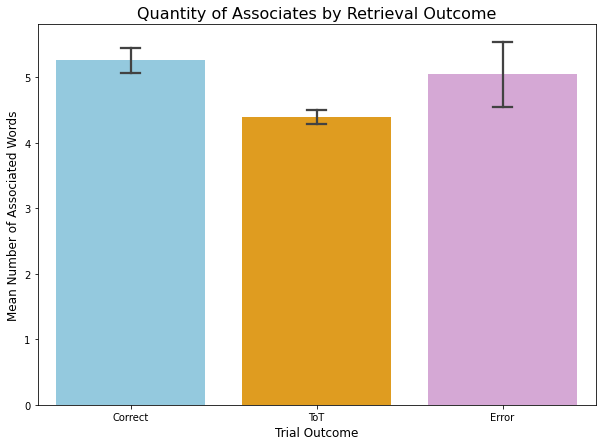

In [10]:
# Filter for Correct, ToT, and Error trials
df_filtered_h2 = df_merged[df_merged['Score'].isin(['Correct', 'ToT', 'Error'])]

# Separate the data into three groups for the ANOVA test
correct_associates = df_filtered_h2[df_filtered_h2['Score'] == 'Correct']['Number_of_Associate'].dropna()
tot_associates = df_filtered_h2[df_filtered_h2['Score'] == 'ToT']['Number_of_Associate'].dropna()
error_associates = df_filtered_h2[df_filtered_h2['Score'] == 'Error']['Number_of_Associate'].dropna()

# Perform one-way ANOVA to compare the means of the three groups
f_stat, p_value_anova = f_oneway(correct_associates, tot_associates, error_associates)

# Print the descriptive and inferential statistics
print(f"Mean associates for Correct trials: {correct_associates.mean():.2f}")
print(f"Mean associates for ToT trials: {tot_associates.mean():.2f}")
print(f"Mean associates for Error trials: {error_associates.mean():.2f}")
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA P-value: {p_value_anova:.4f}\n")


# --- Updated Visualization for Hypothesis 2 ---
plt.figure(figsize=(10, 7))
sns.barplot(
    x='Score',
    y='Number_of_Associate',
    data=df_filtered_h2,
    palette=['skyblue', 'orange', 'plum'],
    order=['Correct', 'ToT', 'Error'],
    capsize=.1
)
plt.title('Quantity of Associates by Retrieval Outcome', fontsize=16)
plt.xlabel('Trial Outcome', fontsize=12)
plt.ylabel('Mean Number of Associated Words', fontsize=12)
plot_save_path = os.path.join(output_dir, 'quantity_associates.png')
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()

# 7) Hypothesis 3:  ToT and Quality of Semantic Activation

Loading word embedding model from: /Users/borghesani/Documents/5_Students/UNIGE_master_students/5_Neuro/Lina_Languer/cc.fr.300.bin...
Model loaded successfully.
Calculating semantic distances for each trial...
Semantic distances calculated.

Mean semantic distance for Correct trials: 0.7108
Mean semantic distance for ToT trials: 0.7172
Mean semantic distance for Error trials: 0.7128

ANOVA F-statistic: 0.6837
ANOVA P-value: 0.5049



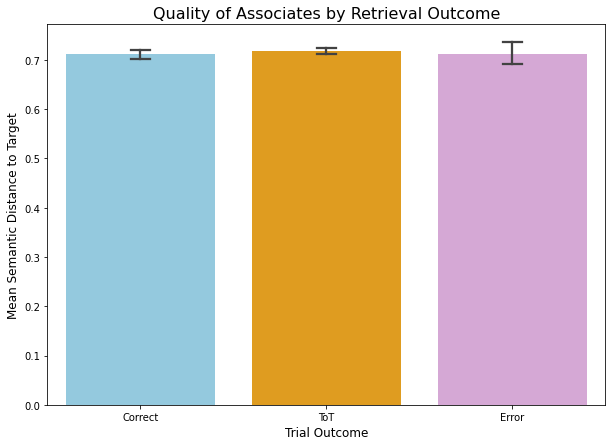

In [11]:
# Load the pre-trained word embedding model
# This step can be time-consuming
if LOAD_EMBEDDINGS:
    try:
        print(f"Loading word embedding model from: {WORD_EMBEDDING_MODEL_PATH}...")
        ft_model = gensim.models.fasttext.load_facebook_vectors(WORD_EMBEDDING_MODEL_PATH)
        # Access the KeyedVectors instance through the .wv attribute
        model = ft_model.wv
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Word embedding model not found at {WORD_EMBEDDING_MODEL_PATH}")
        print("Skipping Hypothesis 3 analysis.")
        model = None
else:
    print("Skipping word embedding model load as per configuration.")
    model = None

if model:
    # Calculate semantic distance for each trial in the association task
    print("Calculating semantic distances for each trial...")
    df_merged['Semantic_Distance'] = df_merged.apply(
        lambda row: calculate_semantic_distance(row['Target_Word'], row['Associates'], model),
        axis=1
    )
    print("Semantic distances calculated.")

    # Filter for trials where semantic distance could be computed and are relevant
    df_filtered_h3 = df_merged[df_merged['Score'].isin(['Correct', 'ToT', 'Error'])].dropna(subset=['Semantic_Distance'])

    # Separate the data into groups for ANOVA
    correct_distance = df_filtered_h3[df_filtered_h3['Score'] == 'Correct']['Semantic_Distance']
    tot_distance = df_filtered_h3[df_filtered_h3['Score'] == 'ToT']['Semantic_Distance']
    error_distance = df_filtered_h3[df_filtered_h3['Score'] == 'Error']['Semantic_Distance']

    # --- Statistical Analysis ---
    # Perform one-way ANOVA
    f_stat_h3, p_value_anova_h3 = f_oneway(correct_distance, tot_distance, error_distance)

    # Print descriptive and inferential statistics
    print(f"\nMean semantic distance for Correct trials: {correct_distance.mean():.4f}")
    print(f"Mean semantic distance for ToT trials: {tot_distance.mean():.4f}")
    print(f"Mean semantic distance for Error trials: {error_distance.mean():.4f}")
    print(f"\nANOVA F-statistic: {f_stat_h3:.4f}")
    print(f"ANOVA P-value: {p_value_anova_h3:.4f}\n")

    # --- Visualization ---
    plt.figure(figsize=(10, 7))
    sns.barplot(
        x='Score',
        y='Semantic_Distance',
        data=df_filtered_h3,
        palette=['skyblue', 'orange', 'plum'],
        order=['Correct', 'ToT', 'Error'],
        capsize=.1
    )
    plt.title('Quality of Associates by Retrieval Outcome', fontsize=16)
    plt.xlabel('Trial Outcome', fontsize=12)
    plt.ylabel('Mean Semantic Distance to Target', fontsize=12)
    plot_save_path = os.path.join(output_dir, 'quanlity_associates.png')
    plt.savefig(plot_save_path, bbox_inches='tight')
    plt.show()